In [10]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import torch
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt
from torchvision.models import resnet50


from lightning.pytorch import Trainer
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from src.datasets import DatasetBuilder
from src.models.classifiers import SimpleCNNtorch
from src.models.lightning_wrappers import ClassifierLightningWrapper 
from src.utils import seed_everything, get_config, load_model_weights, evaluate_classification_model

In [2]:
seed_everything()

## Setup a builder of the dataset and a config file

In [ ]:
config_path = r"/data/leuven/365/vsc36567/CF-Robustness-Benchmark/configs/train_classifier_fmnist.yaml"
# r"D:\PycharmProjects\CF-Robustness-Benchmark\configs\train_classifier_fmnist.yaml"
config = get_config(config_path)

In [4]:
# Uncomment for multiclass classification
config.data.classes = [0, 2, 4, 6]
config.data.num_classes = len(config.data.classes)

In [5]:
ds_builder = DatasetBuilder(config)
ds_builder.setup()
train_loader, val_loader, test_loader = ds_builder.get_dataloaders()

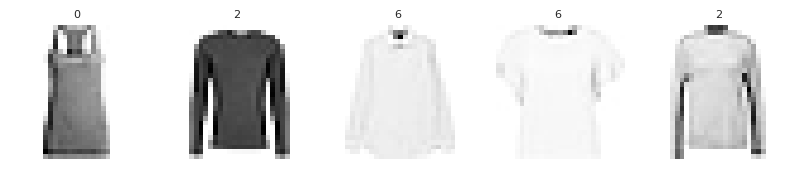

In [6]:
plt.style.use('seaborn-v0_8-darkgrid')

n_samples = 5
class_names = ds_builder.class_encodings
fig, axs = plt.subplots(1, n_samples, figsize=(10, 6))

batch = next(iter(train_loader))
images = batch[0][:n_samples]
labels = batch[1][:n_samples]

for i in range(n_samples):
    axs[i].imshow(images[i, ...].permute(1, 2, 0))
    axs[i].set_title(class_names[labels[i].item()], fontdict={'fontsize': 8})
    axs[i].axis("off")

### Build a classification model

In [12]:
model = SimpleCNNtorch(**config.classifier.args, 
                        img_size=config.data.img_size,
                        num_classes=config.data.num_classes)
lwrapper = ClassifierLightningWrapper(config, model)

In [13]:
expt_dir = r"/data/leuven/365/vsc36567/CF-Robustness-Benchmark/notebooks/experiments"
# r"D:\PycharmProjects\CF-Robustness-Benchmark\notebooks\experiments"
expt_name = f"{config.data.name}_classification"
expt_version = "binary"  if config.data.num_classes == 2 else "multiclass"
checkpints_dir = osp.join(expt_dir, expt_name, expt_version, 'checkpoints')
classes4fname = ("_").join([str(i) for i in class_names.values()]) if config.data.num_classes == 2 else ""

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=5,
    verbose=False,
    mode="min",

)

chekpoint_callback = ModelCheckpoint(
    monitor="val_accuracy",
    dirpath=checkpints_dir,
    filename=f"{config.data.name}_{classes4fname}_{{epoch:02d}}_{{val_accuracy:.2f}}",
    save_top_k=1,
    mode="max",
    save_weights_only=True,
)
chekpoint_callback.FILE_EXTENSION = '.pth'

tb_logger = TensorBoardLogger(save_dir=expt_dir, name=expt_name, version=expt_version)

trainer = Trainer(
    log_every_n_steps=10,
    max_epochs=config.epochs+3,
    enable_checkpointing=True,
    callbacks=[early_stop_callback, chekpoint_callback],
    logger=tb_logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model=lwrapper, 
            train_dataloaders=train_loader, 
            val_dataloaders=val_loader)

In [ ]:
model_weights_path = r"D:\PycharmProjects\CF-Robustness-Benchmark\notebooks\experiments\mnist_classification\binary\checkpoints\mnist_1_8_epoch=08_val_loss=0.00.pth"
loaded_model = SimpleCNNtorch(config.input_channels, 
                        config.data.img_size,
                        config.data.num_classes,
                        in_conv_channels=[1, 8, 16],
                        out_conv_channels=[8, 16, 32],
                        conv_kernels=[7, 5, 3],
                        softmax_flag=True)

print('Total number of parameters in the CNN:', loaded_model.get_params_num())

load_model_weights(loaded_model, framework="torch", weights_path=model_weights_path)
evaluate_classification_model(loaded_model, test_loader, config.data.num_classes)

## Classification on DermaMNIST

In [3]:
config_path = r"/data/leuven/365/vsc36567/CF-Robustness-Benchmark/configs/train_classifier_derma.yaml"
# "D:\PycharmProjects\CF-Robustness-Benchmark\configs\train_classifier_derma.yaml"
config = get_config(config_path)

ds_builder = DatasetBuilder(config)
ds_builder.setup()
train_loader, val_loader, test_loader = ds_builder.get_dataloaders()

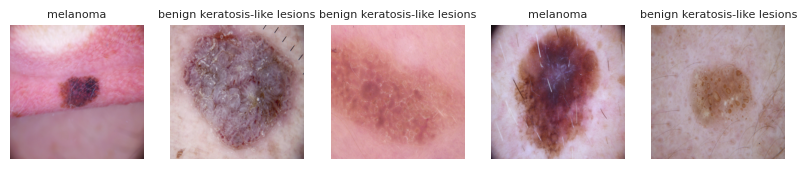

In [6]:
plt.style.use('seaborn-v0_8-darkgrid')

n_samples = 5
class_names = ds_builder.class_encodings
fig, axs = plt.subplots(1, n_samples, figsize=(10, 6))

batch = next(iter(train_loader))
images = batch[0][:n_samples]
labels = batch[1][:n_samples]

for i in range(n_samples):
    axs[i].imshow(images[i, ...].permute(1, 2, 0))
    axs[i].set_title(class_names[labels[i].item()], fontdict={'fontsize': 8})
    axs[i].axis("off")

In [8]:
cnn = resnet50(weights='DEFAULT')
cnn.fc = torch.nn.Linear(cnn.fc.in_features, config.data.num_classes)

In [11]:
labels_count = np.unique(ds_builder.train_dataset.data.labels, return_counts=True)[1]
ds_len =len(ds_builder.train_dataset)
class_weights = torch.Tensor([(1 - count / ds_len).round(4).item() for count in labels_count])
print(class_weights)

tensor([0.5196, 0.4804])


In [12]:
config.loss.args['weight'] = class_weights

In [ ]:
def setup_model(config, class_weights):

    cnn = build_resnet50()
    optimizer_cls = getattr(torch.optim, config.optimizer.name)
    optimizer = optimizer_cls(cnn.parameters(), **config.optimizer.args)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3)
    # lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    loss = getattr(torch.nn, config.loss.name)(**config.loss.args, weight=class_weights)

    return cnn, optimizer, lr_scheduler, loss

In [14]:
lg_wrapper = ClassifierLightningWrapper(config, cnn)

In [16]:
expt_dir = r"/data/leuven/365/vsc36567/CF-Robustness-Benchmark/notebooks/experiments"
# r"D:\PycharmProjects\CF-Robustness-Benchmark\notebooks\experiments"
expt_name = f"derma_classification"
expt_version = "binary"  if config.data.num_classes == 2 else "multiclass"
checkpints_dir = osp.join(expt_dir, expt_name, expt_version, 'checkpoints')

# early_stop_callback = EarlyStopping(
#     monitor="val_loss",
#     min_delta=0.00,
#     patience=3,
#     verbose=False,
#     mode="min",
# )

chekpoint_callback = ModelCheckpoint(
    monitor="train_accuracy",
    dirpath=checkpints_dir,
    filename=f"derma_{{epoch:02d}}_{{train_accuracy:.2f}}",
    save_top_k=1,
    mode="max",
    save_weights_only=True,
)
chekpoint_callback.FILE_EXTENSION = '.pth'

tb_logger = TensorBoardLogger(save_dir=expt_dir, name=expt_name, version=expt_version)

trainer = Trainer(
    log_every_n_steps=5,
    max_epochs=10,
    enable_checkpointing=True,
    callbacks=[chekpoint_callback],
    logger=tb_logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [17]:
trainer.fit(model=lg_wrapper, 
            train_dataloaders=train_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | ResNet           | 23.5 M | train
1 | loss_fn       | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | valid_metrics | MetricCollection | 0      | train
-----------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
158       Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [18]:
evaluate_classification_model(cnn, test_loader, num_classes=2)

Accuracy for the test dataset: 57.917%
